# Generative Models as Data Augmentation in the Medical Domain

## 1. Overview

This project tries to evaluate the quality of generative models for data augmentation in the medical domain. 

Data augmentation will be relying on geometric data augmentation, (variational) auto-encoder (e.g. stacked denoising, denoising auto-encoder, etc.), and generative adversarial neural networks (e.g. GAN, DCGAN, Wasserstein GAN, etc.) for instance.

We will restrict ourself to three kind of models to generate new data and evaluate the (possible) improvement with regards to a final classification score (i.e. comparing results between augmented and non-augmented training sets). 

### Datasets

We will look into applying the above project on some (if not all) of the following datasets from the MedMNIST Classification Decathlon (https://medmnist.github.io/):

| Dataset | Classification Type | Train size | Validation size | Test size |
| :--- | :--- | :---: | :---: | :---: |  
| PathMNIST Pathology | Multi-Class (9) | 89,996 | 10,004 | 7,180 |
| DermaMNIST Dermatoscope | Multi-Class (7) | 7,007 | 1,003 | 2,005 |
| OCTMNIST OCT | Multi-Class (4) | 97,477 | 10,832 | 1,000 |
| PneumoniaMNIST Chest X-ray | Binary-Class (2) |4,708 | 524 | 624 |
| BreastMNIST Breast Ultrasound | Binary-Class (2) | 546 | 78 | 156 |
| OrganMNIST_Axial Abdominal CT | Multi-Class (11) | 34,581 | 6,491 | 17,778 |
| OragnMNIST_Coronal Abdominal CT | Multi-Class (11) |13,000 | 2,392 | 8,268 |
| OrganMNIST_Sagittal Abdominal CT | Multi-Class (11) | 13,940 | 2,452 | 8,829 |

### Notes

We will also provide a short report (in copy) explaining the choice of VAE, AE, and/or GAN models, outlining differences between datasets' results. We will also try to interprete and justify possible differences with regards to models, data specifications, visual features, and bibliography references used to support the choices made.

## 2. Data and Library Imports

### Source

We will retrieve the above dataset from the following website:

> [MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification](https://medmnist.com/), Jiancheng Yang,Rui Shi,Donglai Wei,Zequan Liu,Lin Zhao,Bilian Ke,Hanspeter Pfister,Bingbing Ni

By following the instructions on their [github](https://github.com/MedMNIST/MedMNIST), we can download their ready-made module with the following instruction:

```sh
pip install jupyter, ipywidgets, IProgress
pip install medmnist
```

And load it in a python or ipython instance:

```python
import medmnist
```

### Library Imports

In [1]:
from python_scripts.classifier import run_classifier_pipeline
from python_scripts.conditional_vae import run_encoder_pipeline, one_hot
from python_scripts.data import retrieve_flag_info, import_dataset
from python_scripts.data import check_cuda_availability

import warnings
warnings.filterwarnings('ignore')

### Checks CUDA availability

In [2]:
check_cuda_availability()

True,0,<torch.cuda.device object at 0x7f87283f3a90>,1
NVIDIA GeForce GTX 980 Ti


### Data Imports

In [3]:
data_flags = ["pathmnist", "dermamnist", "octmnist", "pneumoniamnist", 
              "breastmnist", "organamnist", "organcmnist", "organsmnist"]

info_flags = {flag:retrieve_flag_info(flag) for flag in data_flags}

In [ ]:
pathmnist = import_dataset("pathmnist", info_flags)

Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Montage of randomly extracted images from the dataset:


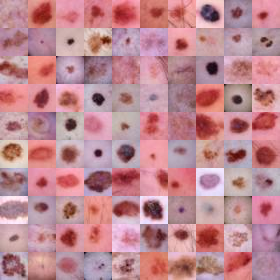

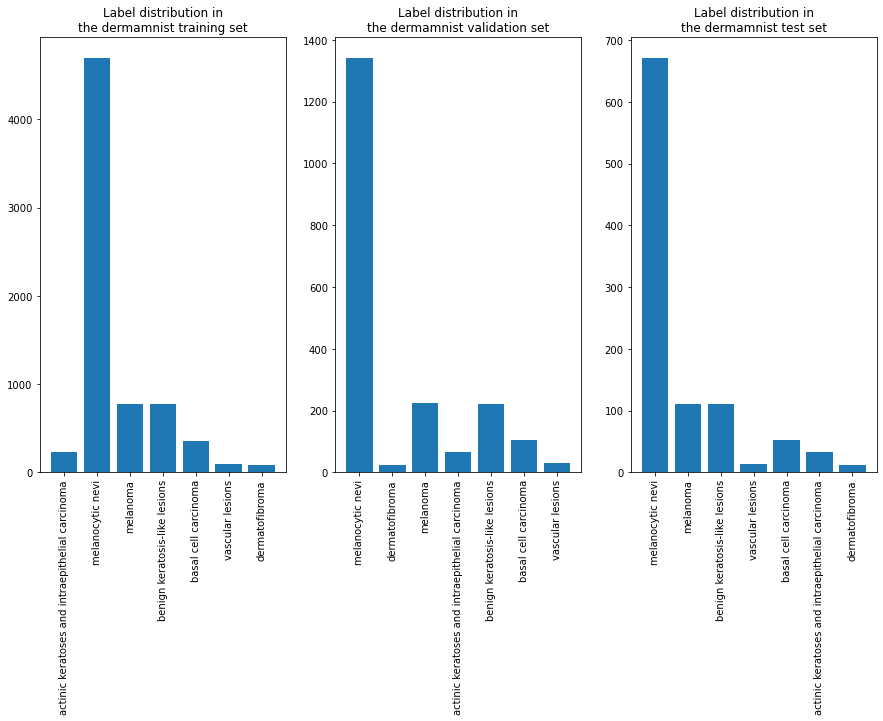

In [4]:
dermamnist = import_dataset("dermamnist", info_flags)

In [ ]:
octmnist = import_dataset("octmnist", info_flags)

In [ ]:
pneumoniamnist = import_dataset("pneumoniamnist", info_flags)

In [ ]:
breastmnist = import_dataset("breastmnist", info_flags)

In [ ]:
organamnist = import_dataset("organamnist", info_flags)

In [ ]:
organcmnist = import_dataset("organcmnist", info_flags)

In [ ]:
organsmnist = import_dataset("organsmnist", info_flags)

## 3. Training a Classifier Without Data Augmentation

### PathMNIST

In [ ]:
clf_pathmnist = run_classifier_pipeline("pathmnist", info_flags, pathmnist)

### DermaMNIST

In [ ]:
clf_dermamnist = run_classifier_pipeline("dermamnist", info_flags, dermamnist)

### OctMNIST

In [ ]:
clf_octmnist = run_classifier_pipeline("octmnist", info_flags, octmnist)

### PneumoniaMNIST

In [ ]:
clf_pneumoniamnist = run_classifier_pipeline("pneumoniamnist", info_flags, pneumoniamnist)

### BreastMNIST

In [ ]:
clf_breastmnist = run_classifier_pipeline("breastmnist", info_flags, breastmnist)

### OrganAMNIST

In [ ]:
clf_organamnist = run_classifier_pipeline("organamnist", info_flags, organamnist)

### OrganCMNIST

In [ ]:
clf_organcmnist = run_classifier_pipeline("organcmnist", info_flags, organcmnist)

### OrganSMNIST

In [ ]:
clf_organsmnist = run_classifier_pipeline("organsmnist", info_flags, organsmnist)

## 4. Training a Conditional Variational Autoencoder for Data Augmentation

### PathMNIST

### DermaMNIST

In [97]:
n_classes  = len(info_flags["dermamnist"][0]["label"])
n_channels = info_flags["dermamnist"][0]["n_channels"]
laten_dims = 100; epochs = 200

train_loader = dermamnist[3]; val_loader = dermamnist[5]; test_loader = dermamnist[4]

model = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, n_classes, laten_dims, epochs, 
    "dermamnist", 
    output_intermediary_images=True
)

Testing Conditional Variational Autoencoder:
Model Output size: torch.Size([10, 3, 28, 28])
Forward pass test:  True
{'loss': tensor(26247.2012, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(26247.1445, grad_fn=<MseLossBackward0>), 'KLD': tensor(-11.1817, grad_fn=<NegBackward0>)}
Loss test:  True
Cuda device:  cuda
Training phase:
Train epoch 1: [0/7007] 	Loss: 468.062714
Train epoch 1: [1280/7007] 	Loss: 151.809341
Train epoch 1: [2560/7007] 	Loss: 111.330391
Train epoch 1: [3840/7007] 	Loss: 93.618347
Train epoch 1: [5120/7007] 	Loss: 84.858818
Train epoch 1: [6400/7007] 	Loss: 83.334831
Train epoch 1 -- average loss: 121.13853814990813
Validation set loss: 97.313193
Train epoch 2: [0/7007] 	Loss: 73.047577
Train epoch 2: [1280/7007] 	Loss: 67.423897
Train epoch 2: [2560/7007] 	Loss: 57.020329
Train epoch 2: [3840/7007] 	Loss: 52.583904
Train epoch 2: [5120/7007] 	Loss: 56.316555
Train epoch 2: [6400/7007] 	Loss: 52.699169
Train epoch 2 -- average loss: 58.08009011078207
Val

Train epoch 23: [6400/7007] 	Loss: 12.17537
Train epoch 23 -- average loss: 14.047585680223794
Validation set loss: 14.368743
Train epoch 24: [0/7007] 	Loss: 12.466446
Train epoch 24: [1280/7007] 	Loss: 12.361362
Train epoch 24: [2560/7007] 	Loss: 13.120191
Train epoch 24: [3840/7007] 	Loss: 9.588357
Train epoch 24: [5120/7007] 	Loss: 11.797003
Train epoch 24: [6400/7007] 	Loss: 8.421855
Train epoch 24 -- average loss: 11.850371813593773
Validation set loss: 13.23277
Train epoch 25: [0/7007] 	Loss: 11.223462
Train epoch 25: [1280/7007] 	Loss: 10.233371
Train epoch 25: [2560/7007] 	Loss: 11.060117
Train epoch 25: [3840/7007] 	Loss: 10.160506
Train epoch 25: [5120/7007] 	Loss: 12.925722
Train epoch 25: [6400/7007] 	Loss: 14.394634
Train epoch 25 -- average loss: 11.483448575698855
Validation set loss: 16.528718
Train epoch 26: [0/7007] 	Loss: 11.169564
Train epoch 26: [1280/7007] 	Loss: 11.28476
Train epoch 26: [2560/7007] 	Loss: 11.996506
Train epoch 26: [3840/7007] 	Loss: 16.721632
Tra

Train epoch 47: [5120/7007] 	Loss: 7.446391
Train epoch 47: [6400/7007] 	Loss: 6.891045
Train epoch 47 -- average loss: 7.986542867358645
Validation set loss: 12.438804
Train epoch 48: [0/7007] 	Loss: 7.438116
Train epoch 48: [1280/7007] 	Loss: 7.426537
Train epoch 48: [2560/7007] 	Loss: 8.205617
Train epoch 48: [3840/7007] 	Loss: 10.29895
Train epoch 48: [5120/7007] 	Loss: 7.924272
Train epoch 48: [6400/7007] 	Loss: 7.154338
Train epoch 48 -- average loss: 7.916923408622627
Validation set loss: 10.619958
Train epoch 49: [0/7007] 	Loss: 9.545778
Train epoch 49: [1280/7007] 	Loss: 6.530274
Train epoch 49: [2560/7007] 	Loss: 7.818785
Train epoch 49: [3840/7007] 	Loss: 8.112136
Train epoch 49: [5120/7007] 	Loss: 8.695137
Train epoch 49: [6400/7007] 	Loss: 8.967608
Train epoch 49 -- average loss: 7.687063459698783
Validation set loss: 12.078752
Train epoch 50: [0/7007] 	Loss: 7.740627
Train epoch 50: [1280/7007] 	Loss: 9.529318
Train epoch 50: [2560/7007] 	Loss: 7.506491
Train epoch 50: [3

Train epoch 71: [5120/7007] 	Loss: 6.104136
Train epoch 71: [6400/7007] 	Loss: 5.982399
Train epoch 71 -- average loss: 6.649078782894003
Validation set loss: 10.338478
Train epoch 72: [0/7007] 	Loss: 4.929549
Train epoch 72: [1280/7007] 	Loss: 6.747137
Train epoch 72: [2560/7007] 	Loss: 5.681043
Train epoch 72: [3840/7007] 	Loss: 8.310618
Train epoch 72: [5120/7007] 	Loss: 5.82998
Train epoch 72: [6400/7007] 	Loss: 6.714299
Train epoch 72 -- average loss: 7.037227926231135
Validation set loss: 10.393319
Train epoch 73: [0/7007] 	Loss: 7.9507
Train epoch 73: [1280/7007] 	Loss: 5.960888
Train epoch 73: [2560/7007] 	Loss: 7.762048
Train epoch 73: [3840/7007] 	Loss: 12.533134
Train epoch 73: [5120/7007] 	Loss: 5.239221
Train epoch 73: [6400/7007] 	Loss: 7.764079
Train epoch 73 -- average loss: 6.918091116472813
Validation set loss: 10.295559
Train epoch 74: [0/7007] 	Loss: 6.474926
Train epoch 74: [1280/7007] 	Loss: 5.80119
Train epoch 74: [2560/7007] 	Loss: 6.242815
Train epoch 74: [3840

Train epoch 95: [6400/7007] 	Loss: 6.505424
Train epoch 95 -- average loss: 5.971326751512996
Validation set loss: 9.924432
Train epoch 96: [0/7007] 	Loss: 6.532693
Train epoch 96: [1280/7007] 	Loss: 4.952181
Train epoch 96: [2560/7007] 	Loss: 5.342642
Train epoch 96: [3840/7007] 	Loss: 4.925117
Train epoch 96: [5120/7007] 	Loss: 5.719289
Train epoch 96: [6400/7007] 	Loss: 7.213521
Train epoch 96 -- average loss: 5.710518633500985
Validation set loss: 10.484145
Train epoch 97: [0/7007] 	Loss: 5.597833
Train epoch 97: [1280/7007] 	Loss: 4.707571
Train epoch 97: [2560/7007] 	Loss: 5.056387
Train epoch 97: [3840/7007] 	Loss: 5.244353
Train epoch 97: [5120/7007] 	Loss: 5.473872
Train epoch 97: [6400/7007] 	Loss: 11.139689
Train epoch 97 -- average loss: 5.923767377293466
Validation set loss: 12.548762
Train epoch 98: [0/7007] 	Loss: 14.937329
Train epoch 98: [1280/7007] 	Loss: 5.856197
Train epoch 98: [2560/7007] 	Loss: 6.127387
Train epoch 98: [3840/7007] 	Loss: 8.415778
Train epoch 98: [

Train epoch 119: [2560/7007] 	Loss: 6.511995
Train epoch 119: [3840/7007] 	Loss: 5.580869
Train epoch 119: [5120/7007] 	Loss: 5.412194
Train epoch 119: [6400/7007] 	Loss: 7.048765
Train epoch 119 -- average loss: 6.0419284607691415
Validation set loss: 11.039503
Train epoch 120: [0/7007] 	Loss: 5.650797
Train epoch 120: [1280/7007] 	Loss: 6.702204
Train epoch 120: [2560/7007] 	Loss: 6.638484
Train epoch 120: [3840/7007] 	Loss: 11.250517
Train epoch 120: [5120/7007] 	Loss: 4.247619
Train epoch 120: [6400/7007] 	Loss: 4.170093
Train epoch 120 -- average loss: 5.682054256429954
Validation set loss: 9.964531
Train epoch 121: [0/7007] 	Loss: 4.491308
Train epoch 121: [1280/7007] 	Loss: 5.198172
Train epoch 121: [2560/7007] 	Loss: 4.841362
Train epoch 121: [3840/7007] 	Loss: 5.64515
Train epoch 121: [5120/7007] 	Loss: 4.588779
Train epoch 121: [6400/7007] 	Loss: 5.081669
Train epoch 121 -- average loss: 5.511281508495689
Validation set loss: 10.046724
Train epoch 122: [0/7007] 	Loss: 9.94132

Validation set loss: 10.370761
Train epoch 143: [0/7007] 	Loss: 6.340706
Train epoch 143: [1280/7007] 	Loss: 4.429415
Train epoch 143: [2560/7007] 	Loss: 6.693852
Train epoch 143: [3840/7007] 	Loss: 4.512681
Train epoch 143: [5120/7007] 	Loss: 5.167647
Train epoch 143: [6400/7007] 	Loss: 5.275331
Train epoch 143 -- average loss: 5.463825629239622
Validation set loss: 10.757424
Train epoch 144: [0/7007] 	Loss: 9.190449
Train epoch 144: [1280/7007] 	Loss: 4.300486
Train epoch 144: [2560/7007] 	Loss: 5.768312
Train epoch 144: [3840/7007] 	Loss: 3.862914
Train epoch 144: [5120/7007] 	Loss: 7.592807
Train epoch 144: [6400/7007] 	Loss: 5.314961
Train epoch 144 -- average loss: 5.317377834393564
Validation set loss: 9.485931
Train epoch 145: [0/7007] 	Loss: 6.185503
Train epoch 145: [1280/7007] 	Loss: 4.85333
Train epoch 145: [2560/7007] 	Loss: 3.895291
Train epoch 145: [3840/7007] 	Loss: 5.591205
Train epoch 145: [5120/7007] 	Loss: 4.002324
Train epoch 145: [6400/7007] 	Loss: 6.649085
Train 

Train epoch 166: [5120/7007] 	Loss: 4.572064
Train epoch 166: [6400/7007] 	Loss: 3.740248
Train epoch 166 -- average loss: 4.434098415883781
Validation set loss: 8.753134
Train epoch 167: [0/7007] 	Loss: 4.704399
Train epoch 167: [1280/7007] 	Loss: 4.197145
Train epoch 167: [2560/7007] 	Loss: 3.851673
Train epoch 167: [3840/7007] 	Loss: 3.546546
Train epoch 167: [5120/7007] 	Loss: 4.010245
Train epoch 167: [6400/7007] 	Loss: 4.012753
Train epoch 167 -- average loss: 4.258059367041998
Validation set loss: 10.623022
Train epoch 168: [0/7007] 	Loss: 4.622177
Train epoch 168: [1280/7007] 	Loss: 4.546806
Train epoch 168: [2560/7007] 	Loss: 3.736486
Train epoch 168: [3840/7007] 	Loss: 4.255488
Train epoch 168: [5120/7007] 	Loss: 4.086903
Train epoch 168: [6400/7007] 	Loss: 3.518676
Train epoch 168 -- average loss: 4.639141916258964
Validation set loss: 8.886953
Train epoch 169: [0/7007] 	Loss: 5.696008
Train epoch 169: [1280/7007] 	Loss: 7.131234
Train epoch 169: [2560/7007] 	Loss: 3.423192


Train epoch 190: [2560/7007] 	Loss: 4.979542
Train epoch 190: [3840/7007] 	Loss: 5.741943
Train epoch 190: [5120/7007] 	Loss: 4.639614
Train epoch 190: [6400/7007] 	Loss: 3.677884
Train epoch 190 -- average loss: 4.488165355501084
Validation set loss: 8.878544
Train epoch 191: [0/7007] 	Loss: 4.433142
Train epoch 191: [1280/7007] 	Loss: 3.815947
Train epoch 191: [2560/7007] 	Loss: 2.884999
Train epoch 191: [3840/7007] 	Loss: 4.35025
Train epoch 191: [5120/7007] 	Loss: 5.531783
Train epoch 191: [6400/7007] 	Loss: 4.065204
Train epoch 191 -- average loss: 4.0131282858115656
Validation set loss: 9.548065
Train epoch 192: [0/7007] 	Loss: 5.98031
Train epoch 192: [1280/7007] 	Loss: 4.035145
Train epoch 192: [2560/7007] 	Loss: 4.05748
Train epoch 192: [3840/7007] 	Loss: 3.536767
Train epoch 192: [5120/7007] 	Loss: 3.181381
Train epoch 192: [6400/7007] 	Loss: 4.083313
Train epoch 192 -- average loss: 4.26760267581888
Validation set loss: 9.174013
Train epoch 193: [0/7007] 	Loss: 4.210321
Trai

In [98]:
import torch

img = model.sample(1, one_hot(torch.Tensor([1]).int().to(torch.device("cuda")), 7))

In [99]:
img.detach().cpu().numpy().reshape([3, 28, 28]).T.shape

(28, 28, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


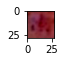

In [111]:
import matplotlib.pyplot as plt
def show_images(images) -> None:
    n: int = len(images)
    f = plt.figure(figsize=(0.5, 0.5))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)
    
show_images([img.detach().cpu().numpy().reshape([3, 28, 28]).T])

-20.30531

### OctMNIST

### PneumoniaMNIST

### BreastMNIST

### OrganAMNIST

### OrganCMNIST

### OrganSMNIST